신용카드 거래 사기탐지 TRY 변형

# import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx
import sklearn

# sklearn
from sklearn import model_selection 
from sklearn import ensemble
from sklearn import metrics 

# embedding 
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder

In [2]:
# 이분그래프
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df=df_input.copy()
    mapping={x:node_id for node_id, x in enumerate(set(df["cc_num"].values.tolist()+\
                                                      df["merchant"].values.tolist()))}
    
    df["from"]=df["cc_num"].apply(lambda x:mapping[x])  
    df["to"]=df["merchant"].apply(lambda x:mapping[x])  
    
    df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from','to']).agg({"is_fraud":"sum","amt":"sum"}).reset_index()
    df["is_fraud"]=df["is_fraud"].apply(lambda x:1 if x>0 else 0)
    
    G=nx.from_edgelist(df[["from","to"]].values, create_using=graph_type)
    
    nx.set_edge_attributes(G,{(int(x["from"]),int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, "label")  #엣지 속성 설정,각 속성의 사기 여부부     
    nx.set_edge_attributes(G,{(int(x["from"]),int(x["to"])):x["amt"] for idx,x in df[["from","to","amt"]].iterrows()}, "weight") # 엣지 속성 설정, 각 엣지의 거래 금액

    return G


# 삼분그래프
def build_graph_tripartite(df_input, graph_type=nx.Graph()):
    df=df_input.copy()
    mapping={x:node_id for node_id, x in enumerate(set(df.index.values.tolist() + 
                                                       df["cc_num"].values.tolist() +
                                                       df["merchant"].values.tolist()))}
    df["in_node"]= df["cc_num"].apply(lambda x: mapping[x])
    df["out_node"]=df["merchant"].apply(lambda x:mapping[x])
    
        
    G=nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +\
                        [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], create_using=graph_type)
    
    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")     
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")   
    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")  
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")

    return G
    
    
    
def down_sample_textbook(df):
    df_majority = df[df.is_fraud==0].copy()
    df_minority = df[df.is_fraud==1].copy()
    df_maj_dowsampled = sklearn.utils.resample(df_majority, n_samples=len(df_minority), replace=False, random_state=42)
    df_downsampled = pd.concat([df_minority, df_maj_dowsampled])
    return df_downsampled


def embedding(Graph):
    # Graph -> X (feature)
    _edgs = list(Graph.edges)
    subGraph = Graph.edge_subgraph([_edgs[x] for x in range(len(Graph.edges))]).copy()
    subGraph.add_nodes_from(list(set(Graph.nodes) - set(subGraph.nodes)))    
    embedded = AverageEmbedder(Node2Vec(subGraph, weight_key='weight').fit(window=10).wv)
    X = [embedded[str(_edgs[x][0]), str(_edgs[x][1])] for x in range(len(Graph.edges))]
    # Graph -> y (label)
    y = np.array(list(nx.get_edge_attributes(Graph, "label").values()))
    return X,y 

def anal(df):
    Graph = build_graph_bipartite(df)
    X,XX,y,yy = embedding(Graph)
    lrnr = RandomForestClassifier(n_estimators=100, random_state=42) 
    lrnr.fit(X,y)
    yyhat = lrnr.predict(XX)
    df = pd.DataFrame({
        'acc':[sklearn.metrics.accuracy_score(yy,yyhat)], 
        'pre':[sklearn.metrics.precision_score(yy,yyhat)], 
        'rec':[sklearn.metrics.recall_score(yy,yyhat)],
        'f1':[sklearn.metrics.f1_score(yy,yyhat)]}
    )    
    return df

def our_sampling1(df):
    cus_list = set(df.query('is_fraud==1').cc_num.tolist())
    return df.query("cc_num in @ cus_list")

# data정리

`-` 원본데이터

In [3]:
fraudTrain = pd.read_csv("~/Desktop/fraudTrain.csv").iloc[:,1:]
fraudTrain.shape

(1048575, 22)

In [4]:
fraudTrain.is_fraud.mean().round(5)

0.00573

`-` df20

In [5]:
_df1 = fraudTrain[fraudTrain["is_fraud"] == 0].sample(frac=0.2,random_state=42)
_df2 = fraudTrain[fraudTrain["is_fraud"] == 1]
df02 = pd.concat([_df1,_df2])
df02.shape

(214520, 22)

In [6]:
df02.is_fraud.mean().round(5)

0.028

`-` df50

In [7]:
df50 = down_sample_textbook(df02)
df50.shape

(12012, 22)

In [8]:
df50.is_fraud.mean().round(5)

0.5

`-` df50_tr, df50_test

In [9]:
df50_tr, df50_test = sklearn.model_selection.train_test_split(df50, random_state=42)

In [10]:
df50_tr.is_fraud.mean().round(5), df50_test.is_fraud.mean().round(5)

(0.49828, 0.50516)

`-` df02_tr, fraudTrain_tr

In [11]:
df02_tr = df02.loc[[i not in df50_test.index for i in df02.index],:].copy()

In [12]:
df02_tr.shape

(211517, 22)

In [13]:
fraudTrain_tr = fraudTrain.loc[[i not in df50_test.index for i in fraudTrain.index],:].copy()

In [14]:
fraudTrain_tr.shape

(1045572, 22)

- df02_tr과 fraudTrain_tr은 test50_test와 겹치지 않는 걸로

In [15]:
df02_tr.is_fraud.mean().round(5)

0.02122

In [16]:
fraudTrain_tr.is_fraud.mean().round(5)

0.00429

|데이터|shape|사기거래빈도|설명|
|--|--|--|--|
|fraudTrain|(1048575,22)|0.00573|원본|
|df02|(214520,22)|0.028|is_fraud==0에서 20퍼 샘플만 뽑음, is_fraud==1은 100퍼|
|df50|(12012,22)|0.5|df02에서 사기비율을 50퍼 맞추어 샘플링 한 자료|
|df50_tr|(9009,22)|0.49828|df50에서 랜덤으로 train분리|
|df50_test|(3003,22)|0.50516|df50에서 랜덤으로 tst분리|
|df02_tr|(211517,22)|0.02122|df02에서 df50_test를 제외|
|fraudTrain_tr|(1045572,22)|0.00429|fraudTrain에서 df50_test제외|

# try 변형

## 분석1

`-` step1: data

In [19]:
X = np.array(df02_tr.loc[:,['amt']])
XX = np.array(df50_test.loc[:,['amt']])
y = np.array(df02_tr.is_fraud)
yy = np.array(df50_test.is_fraud)

`-` step2: lrnr

In [18]:
lrnr = ensemble.GradientBoostingClassifier()

`-` step3: fit

In [20]:
lrnr.fit(X,y)

GradientBoostingClassifier()

`-` step4: evaluate

In [21]:
thresh = y.mean()
yyhat = (lrnr.predict_proba(XX)> thresh)[:,-1]
#yyhat = lrnr.predict(XX) 

In [22]:
metrics = [sklearn.metrics.accuracy_score,
           sklearn.metrics.precision_score,
           sklearn.metrics.recall_score,
           sklearn.metrics.f1_score]

In [24]:
_results1= pd.DataFrame({m.__name__:[m(yy,yyhat).round(6)] for m in metrics},index=['분석1'])
_results1

,accuracy_score,precision_score,recall_score,f1_score
분석1,0.88678,0.910677,0.86025,0.884746


## 분석2

`-` step1: data

In [36]:
def amtano(df_train):
    df = df_train.copy()
    df = df.assign(amtano1=0)
    df = df.assign(amtano2=0)
    df = df.assign(amtano3=0)
    normalize = lambda arr: (arr-np.median(arr)) if np.std(arr)!=0 else arr*0 
    rollmax = lambda arr: arr.rolling(window=3, min_periods=1).max()
    rollmin = lambda arr: arr.rolling(window=3, min_periods=1).min()    
    rollmean = lambda arr: arr.rolling(window=3, min_periods=1).mean()    
    rollstd = lambda arr: arr.rolling(window=3, min_periods=1).std()    
    for cc_num, sub_df in df.groupby('cc_num'):
        df.loc[df.cc_num == cc_num,['amtano1']] = normalize(sub_df.amt)
        df.loc[df.cc_num == cc_num,['amtano2']] = (sub_df.amt * rollmean(normalize(sub_df.amt)))/rollmin(sub_df.amt)
        df.loc[df.cc_num == cc_num,['amtano3']] = rollmin(normalize(sub_df.amt))
    return df  

In [37]:
df02_tr2 = amtano(df02_tr)
df50_test2 = amtano(df50_test)

X = np.array(df02_tr2.loc[:,['amtano2']])
XX = np.array(df50_test2.loc[:,['amtano2']])
y = np.array(df02_tr.is_fraud)
yy = np.array(df50_test.is_fraud)

In [38]:
cclist = df02_tr2.cc_num.unique().tolist()

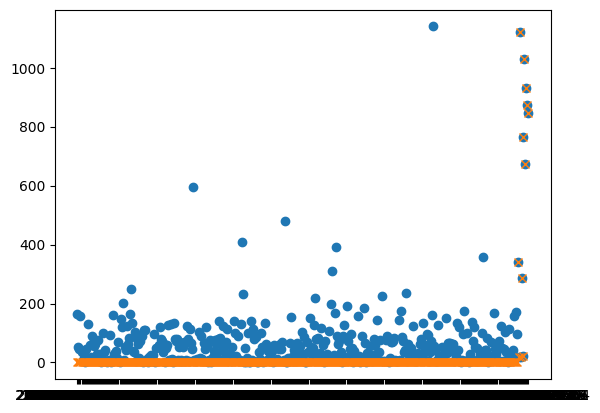

In [39]:
i=190
plt.plot(df02_tr2.query('cc_num==@cclist[@i]').trans_date_trans_time, df02_tr2.query('cc_num==@cclist[@i]').amt,'o')
plt.plot(df02_tr2.query('cc_num==@cclist[@i]').trans_date_trans_time, df02_tr2.query('cc_num==@cclist[@i]').is_fraud*df02_tr2.query('cc_num==@cclist[@i]').amt,'x')

`-` step2: lrnr

In [40]:
lrnr = ensemble.GradientBoostingClassifier()

`-` step3: fit

In [41]:
lrnr.fit(X,y)

GradientBoostingClassifier()

`-` step4: evaluate

In [42]:
# thresh = y.mean()
# yyhat = (lrnr.predict_proba(XX)> thresh)[:,-1]
yyhat = lrnr.predict(XX) 

In [43]:
metrics = [sklearn.metrics.accuracy_score,
           sklearn.metrics.precision_score,
           sklearn.metrics.recall_score,
           sklearn.metrics.f1_score]

In [44]:
_results2= pd.DataFrame({m.__name__:[m(yy,yyhat).round(6)] for m in metrics},index=['분석2'])
_results2

,accuracy_score,precision_score,recall_score,f1_score
분석2,0.53047,0.908397,0.078444,0.144417


## 분석 정리

In [35]:
pd.concat([_results1,_results2])

,accuracy_score,precision_score,recall_score,f1_score
분석1,0.88678,0.910677,0.860250,0.884746
분석2,0.53047,0.908397,0.078444,0.144417
